In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy
import matplotlib.pyplot as plt
import astropy.constants

In [2]:
# Time to sweep
t_start = Time('2021-02-28 00:00:00')
t_end = Time('2021-03-07 00:00:00')

# Observer location
ea4gpz = EarthLocation(lat = 40.595865*u.deg, lon = -3.699069*u.deg, height=800*u.m)

# Antenna pointing
azimuth = 138.84*u.deg
elevation = 34.10*u.deg

In [3]:
t_step = 10*u.s
t = t_start + np.arange((t_end-t_start)/t_step)*t_step

dish_pointing = SkyCoord(AltAz(az = azimuth * np.ones(t.size), alt = elevation*np.ones(t.size),\
                               location = ea4gpz, obstime = t))
sun = astropy.coordinates.get_sun(t)
separation = sun.separation(dish_pointing)

In [4]:
events = list()
for s in t[separation < 1*u.deg]:
    if len(events) == 0 or s - events[-1][1] > 10*u.min:
        events.append([s,s])
    else:
        events[-1][1] = s

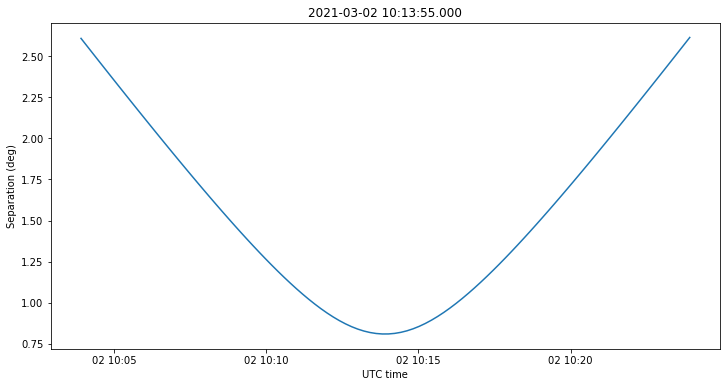

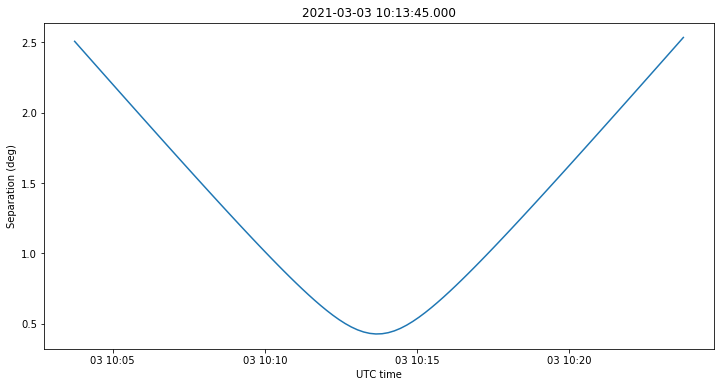

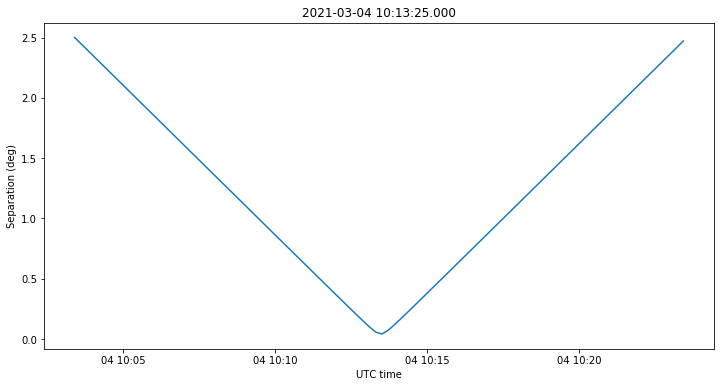

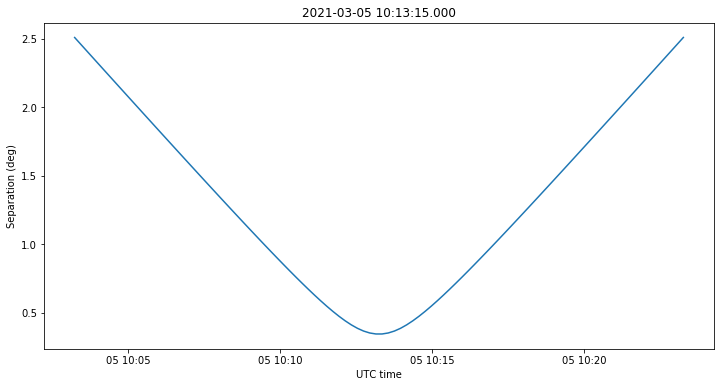

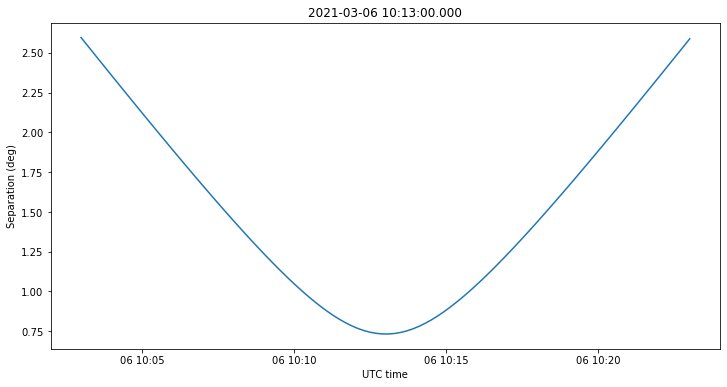

In [5]:
for event in events:
    t0 = event[0] + 0.5*(event[1]-event[0]) 
    time = t0 + np.linspace(-1,1,100) * 10 * u.min
    dish_pointing = SkyCoord(AltAz(az = azimuth * np.ones(time.size), alt = elevation * np.ones(time.size),\
                               location = ea4gpz, obstime = time))
    plt.figure(figsize = (12,6), facecolor = 'w')
    plt.plot(time.datetime, astropy.coordinates.get_sun(time).separation(dish_pointing))
    plt.title(t0)
    plt.xlabel('UTC time')
    plt.ylabel('Separation (deg)')

In [6]:
noise_pwr = np.fromfile('sun_202103/power_f32_2021-02-28T21:23:34.586084', dtype = 'float32')
noise_t = np.datetime64('2021-02-28T21:23:34.586084') + np.arange(noise_pwr.size) * np.timedelta64(1, 's')

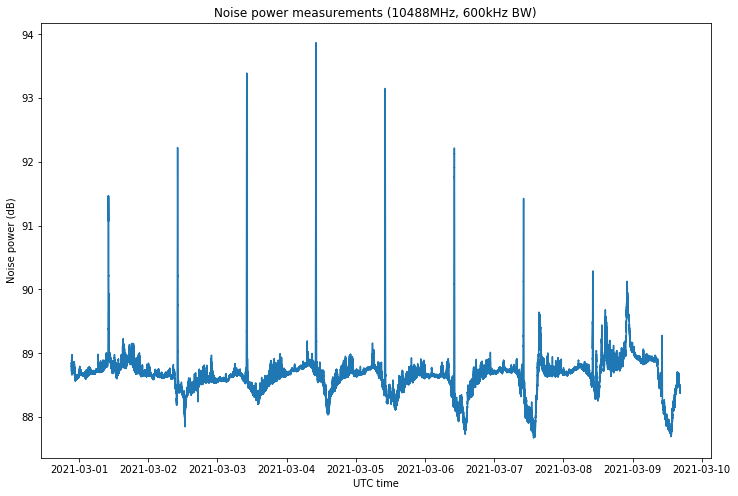

In [7]:
secs_in_day = 3600 * 24
plt.figure(figsize = (12,8), facecolor = 'w')
plt.plot(noise_t, 10*np.log10(noise_pwr))
plt.title('Noise power measurements (10488MHz, 600kHz BW)')
plt.xlabel('UTC time')
plt.ylabel('Noise power (dB)');

In [8]:
pwr_by_day = noise_pwr[:noise_pwr.size//secs_in_day*secs_in_day].reshape((-1, secs_in_day))
t_by_day = noise_t[:noise_pwr.size//secs_in_day*secs_in_day].astype('<M8[us]').reshape((-1, secs_in_day))
peak_loc = np.argmax(pwr_by_day, axis = 1)
span = peak_loc.reshape((-1,1)) + np.arange(-1000,1000).reshape((1,-1))
peaks_by_day = pwr_by_day[np.tile(np.reshape(np.arange(pwr_by_day.shape[0]), (-1,1)), (1,span.shape[1])), span]
t_peaks_by_day = t_by_day[np.tile(np.reshape(np.arange(pwr_by_day.shape[0]), (-1,1)), (1,span.shape[1])), span]
normalization = np.average(peaks_by_day[:,1750:], axis = 1)
peaks_by_day /= normalization.reshape((-1,1))

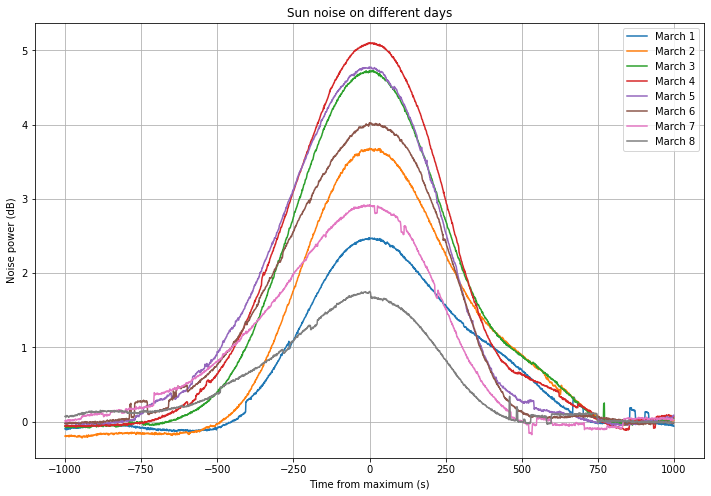

In [9]:
plt.figure(figsize = (12,8), facecolor = 'w')
plt.plot(np.arange(-1000,1000), 10*np.log10(peaks_by_day).transpose())
plt.legend([f'March {n+1}' for n in range(peaks_by_day.shape[0])])
plt.grid()
plt.title('Sun noise on different days')
plt.xlabel('Time from maximum (s)')
plt.ylabel('Noise power (dB)');

In [10]:
10*np.log10(np.max(peaks_by_day))

5.102948546409607

In [11]:
max_times = Time(t_peaks_by_day[:,peaks_by_day.shape[1]//2])
trace_times = Time(t_peaks_by_day)
sun_max = astropy.coordinates.get_sun(max_times).transform_to(AltAz(location = ea4gpz, obstime = max_times))
sun_trace = astropy.coordinates.get_sun(trace_times).transform_to(AltAz(location = ea4gpz, obstime = trace_times))

Spherical angle between sun_max[2] and sun_max[3]

In [12]:
angle = np.arccos(np.sin(sun_max[2].alt) * np.sin(sun_max[3].alt) + np.cos(sun_max[2].alt) * np.cos(sun_max[3].alt) * np.cos(sun_max[2].az - sun_max[3].az))
np.rad2deg(angle)

<Quantity 0.3972157 deg>

In [13]:
angle = np.arccos(np.sin(sun_max[3].alt) * np.sin(sun_max[4].alt) + np.cos(sun_max[3].alt) * np.cos(sun_max[4].alt) * np.cos(sun_max[3].az - sun_max[4].az))
np.rad2deg(angle)

<Quantity 0.38913079 deg>

In [14]:
angle = np.arccos(np.sin(sun_max[3].alt) * np.sin(elevation) + np.cos(sun_max[3].alt) * np.cos(elevation) * np.cos(azimuth - sun_max[3].az))
np.rad2deg(angle)

<Quantity 0.2897638 deg>

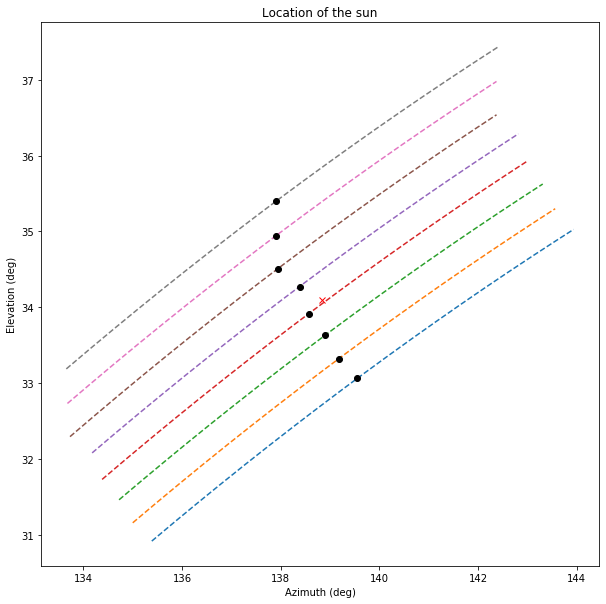

In [15]:
plt.figure(figsize = (10,10), facecolor = 'w')
plt.plot(sun_trace.az.T, sun_trace.alt.T, '--')
plt.plot(sun_max.az, sun_max.alt, 'o', color = 'black')
plt.plot(azimuth, elevation, 'x', color = 'red')
plt.title('Location of the sun')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Elevation (deg)');

In [16]:
measure_sig = peaks_by_day[3,400:1001] - 1
measure_t = Time(t_peaks_by_day[3,400:1001])
dish_pointing = SkyCoord(AltAz(az = sun_max[3].az * np.ones(measure_t.size),
                               alt = sun_max[3].alt * np.ones(measure_t.size),\
                               location = ea4gpz, obstime = measure_t))
sun = astropy.coordinates.get_sun(measure_t)
measure_theta = sun.separation(dish_pointing)
cut = np.argmin(measure_theta)
measure_theta = measure_theta[:cut][::-1]
measure_sig = measure_sig[:cut][::-1]

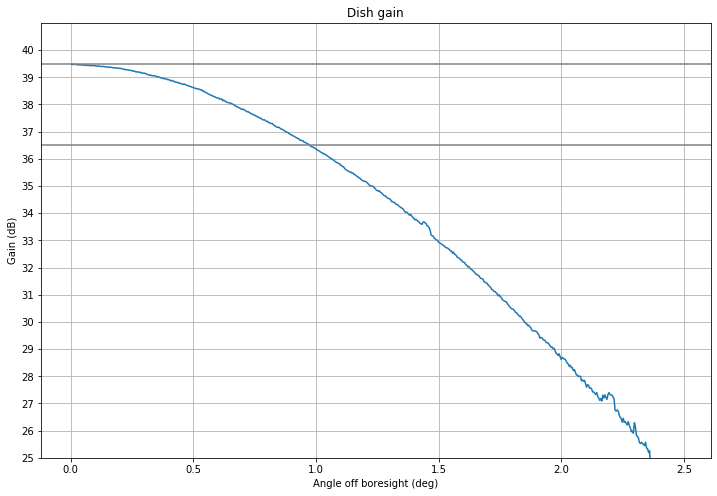

In [17]:
plt.figure(figsize = (12,8), facecolor = 'w')
gain_average = np.trapz(measure_sig * 2 * np.pi * np.sin(measure_theta), x = measure_theta.rad)/(4*np.pi)
plt.plot(measure_theta, 10*np.log10(measure_sig/gain_average))
plt.grid()
plt.yticks(np.arange(25,41))
plt.ylim((25,41))
plt.axhline(39.5, color = 'grey')
plt.axhline(39.5-3, color = 'grey')
plt.ylabel('Gain (dB)')
plt.xlabel('Angle off boresight (deg)')
plt.title('Dish gain');

In [18]:
sfu = 1e4 * u.Jy
flux = 303.3 * sfu
freq = 10488e6 * u.Hz
G = 10**(39.5/10)
aperture = G * freq.to(u.m, equivalencies = u.spectral())**2/(4*np.pi)

In [19]:
aperture

<Quantity 0.57949032 m2>

In [20]:
dish_area = (0.6*u.m)**2*np.pi
efficiency = aperture/dish_area
efficiency

<Quantity 0.51238194>

In [21]:
gamma_atm = 10**(-0.22/10/(np.sin(elevation)))
10*np.log10(gamma_atm)

<Quantity -0.39240938>

In [22]:
gamma_cover = 10**(-0.1/10)
gamma_pointing = 1

In [23]:
L = 1 + 0.38 * (0.5 / 2)**2 # http://www.setileague.org/articles/g-t.htm
gamma_beam = 1/L
10*np.log10(gamma_beam)

-0.10193914768474852

In [24]:
gamma = gamma_atm * gamma_cover * gamma_pointing * gamma_beam
10*np.log10(gamma)

<Quantity -0.59434853>

In [25]:
psd = (0.5 * gamma * flux * aperture).to(u.W/u.Hz)
psd

<Quantity 7.66396912e-21 W / Hz>

In [26]:
(psd / astropy.constants.k_B).to(u.K)

<Quantity 555.09902397 K>

In [27]:
10*np.log10(np.max(peaks_by_day-1))

3.4988614916801453

In [28]:
sky_noise = (psd / astropy.constants.k_B).to(u.K) / np.max(peaks_by_day-1)
sky_noise

<Quantity 248.01863012 K>

In [29]:
10 * np.log10(1 + sky_noise/(300*u.K))

<Quantity 2.61674068>

In [30]:
GT = 10*np.log10(G / sky_noise * u.K)
GT

<Quantity 15.55515696>